In [24]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
import os
import pandas as pd
from pathlib import Path
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits import mplot3d
import csv

%matplotlib inline

In [25]:
angle = 2.4
Cu_ka = 8047.8227

In [27]:
h = 6.62607015 * (10**-34)
c = 299792458
kev_to_j = 1.60218 * (10**-16)

def energy_to_angstrom(kev):
    j = kev * kev_to_j
    lamb = h * c / j
    lamb_A = lamb * (10**10)
    return lamb_A

def angstrom_to_energy(A):
    lamb = A * (10**-10)
    j = h * c / lamb
    return j / kev_to_j

In [28]:
energy_to_angstrom(10)

1.2398393795634253

# LaB6 Scan

## LaB6 Reference Standard

(0.0, 500.0)

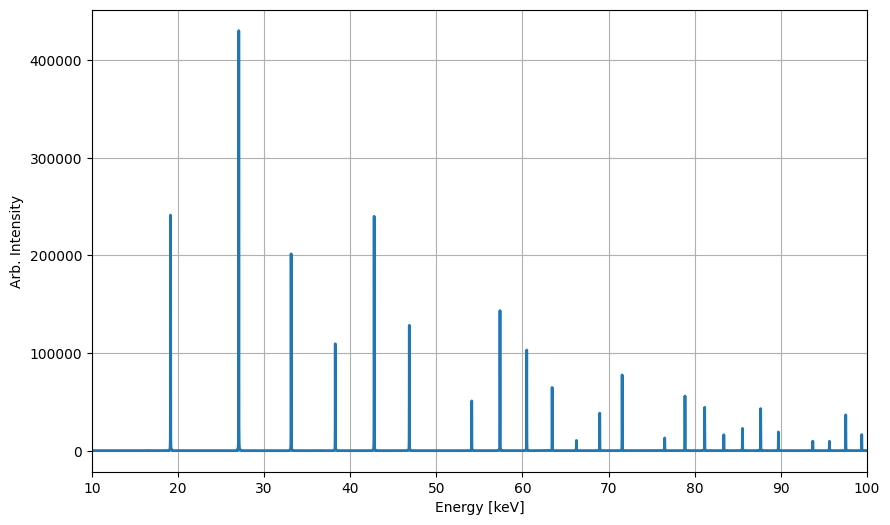

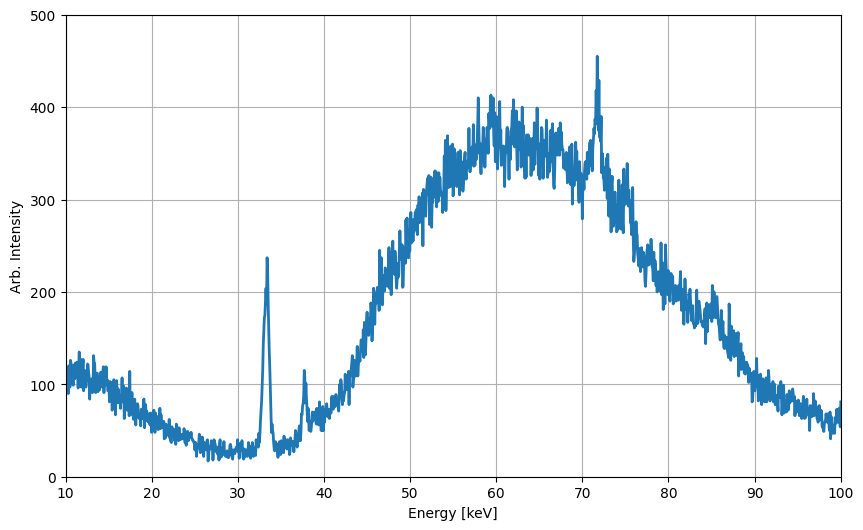

In [48]:
'''
LaB6 Reference Data from 11BM
'''

ref_path = 'EDX Processed Data/11BM_LaB6_660a.csv'
ref_two_theta = []
ref_intensity = []
with open(ref_path, mode ='r')as file:
    csvFile = csv.reader(file)
    not_header = False
    for lines in csvFile:
        if not_header:
            ref_two_theta.append(float(lines[0]))
            ref_intensity.append(float(lines[1]))
        else:
            not_header = True
    file.close()
    
lab6_std = scan(ref_two_theta, ref_intensity, 'two theta', 0)


'''
LaB6 Calibration Data from our Run
'''

cal_path = 'EDX Processed Data/LaB6 Ref.txt'
cal_energy = []
cal_intensity = []
with open(cal_path, 'r') as file:
    flag = False
    for lines in file:
        if flag:
            data = lines.split('\t')
            cal_energy.append(float(data[1]))
            cal_intensity.append(float(data[3]))
        if lines.find('#') > -1:
            flag = True

lab6_cal = scan(cal_energy, cal_intensity, 'energy', 0)
# lab6_cal.set_units('two theta')
lab6_std.set_units('energy')


fig1 = lab6_std.plot()
fig2 = lab6_cal.plot()

fig1[1].set_xlim(10,100)
fig2[1].set_xlim(10,100)
fig2[1].set_ylim(0,500)

## LaB6 Calibration Scan at ID-7 We Ran

In [22]:
class scan:
    
    '''
    ATTRIBUTES AND INITIALIZING
    '''
    
    def __init__(self, x_data, spectrum, units, position):
        self.edxrd_angle = 2.4 #degrees
        self.adxrd_wavelength = 1.5406 #angstrom
        self.valid_units = ['energy', 'momentum', 'two theta'] #valid strings for unit recognition

        self.spectrum = spectrum
        self.position = position
        self.base_units = 'unsigned' #for data-keeping
        
        self.units = 'unsigned' #for plotting
        self.energy = 'unsigned'
        self.momentum = 'unsigned'
        self.two_theta = 'unsigned'
        
        #If the unit is valid, place x-data in the appropriate category
        if (self._valid_unit(units)):
            self.base_units = units
            self.units = units
            if units == 'energy': self.energy = x_data
            elif units == 'momentum': self.momentum = x_data
            elif units == 'two theta': self.two_theta = x_data
        else: return print('Error: Unit not recognized (energy, momentum, or two theta)')
    
        #Using the base unit of given x-data, generate the other ones
        #Example, if units = momentum, calculate x-data in energy and in two-theta
        self._gen_other_units()
    
    '''
    GETTER METHODS
    '''       
    
    def get_spectrum(self): return self.spectrum
    def get_position(self): return self.position
    def get_energy(self): return self.energy
    def get_two_theta(self): return self.two_theta
    def get_momentum(self): return self.momentum
    def get_units(self): return self.units
    def get_base_units(self): return self.base_units
    def get_x_data(self):
        if self.get_units() == 'energy': return self.get_energy()
        if self.get_units() == 'two theta': return self.get_two_theta()
        if self.get_units() == 'momentum': return self.get_momentum()
    def get_x_label(self):
        if self.get_units() == 'energy': return 'Energy [keV]'
        if self.get_units() == 'two theta': return '2\u03B8'
        if self.get_units() == 'momentum': return 'Momentum Transfer [$\AA$$^-$$^1$]'


    '''
    SETTER METHODS
    '''       
    
    def set_edxrd_angle(self, angle): self.edxrd_angle = angle; self._gen_other_units()
    def set_adxrd_wavelength(self, k): self.adxrd_wavelength = k; self._gen_other_units()
    def set_position(self, x): self.position = x
    def set_units(self, unit): 
        if(self._valid_unit): self.units = unit

    '''
    INTERNAL METHODS
    '''
    
    def _valid_unit(self, arb_unit):
        if (arb_unit in self.valid_units):
            return True
        else:
            return False
            
    def _gen_other_units(self):
        dp, ttheta, en = [],[],[]
        
        if self.base_units == 'energy':
            for x in range(len(self.energy)):
                k = 2 * np.pi / energy_to_angstrom(self.energy[x]) #inverse angstroms
                q = 2 * k * np.sin(self.edxrd_angle * np.pi / 180 / 2) #q=2ksin(2theta/2)
                twang = 2 * np.arcsin(q * self.adxrd_wavelength / 4 / np.pi) * 180 / np.pi
                ttheta.append(twang)
                dp.append(q)
            self.momentum = dp
            self.two_theta = ttheta
        
        elif self.base_units == 'two theta':
            for x in range(len(self.two_theta)):
                k = 2 * np.pi / self.adxrd_wavelength #inverse angstroms
                q = 2 * k * np.sin(self.two_theta[x] * np.pi / 180 / 2) #q=2ksin(2theta/2)
                e = angstrom_to_energy((4 * np.pi) / q * np.sin(self.edxrd_angle * np.pi / 180 / 2))
                en.append(e)
                dp.append(q)
            self.momentum = dp
            self.energy = en
            
        elif self.base_units == 'momentum':
            return print("oh crap")
    
    '''
    VISUALIZATION
    '''
    
    def plot(self):
        x = self.get_x_data()
        label = self.get_x_label()
        y = self.get_spectrum()
        fig, ax = plt.subplots(figsize = (10,6))
        ax.plot(x, y, linewidth=2.0)
        ax.set_xlabel(label)
        ax.set_ylabel('Arb. Intensity')
        ax.grid(True)
        return (fig, ax)

In [20]:
class spatial_set:
    
    '''
    ATTRIBUTES AND INITIALIZING
    '''
    
    def __init__(self, scans):

        pos_array = []
        for x in range(len(scans)):
            pos_array.append(scans[x].get_position)
        
        self.positions = pos_array
        self.scan_list = scans
        self.scan_num = len(scans)
        
    '''
    GETTER METHODS
    '''       
    
    def get_scan(self, index): return self.get_scan_list()[index]
    def get_scan_list(self): return self.scan_list
    def get_num_of_scans(self): return self.scan_num
    def get_positions(self): return self.positions

    '''
    SETTER METHODS
    '''       
    
    def set_global_units(self, unit): 
        if unit == 'energy' or unit == 'two theta' or unit == 'momentum':
            for x in range(self.get_num_of_scans()):
                self.scan_list[x].set_units(unit)  
                
    '''
    INTERNAL METHODS
    '''
    
    '''
    VISUALIZATION
    '''
    
    def quick_plot(self):
        fig, ax = plt.subplots(figsize = (10,6))
        label = self.scan_list[0].get_x_label()
        for j in range(self.get_num_of_scans()):
            x = self.scan_list[j].get_x_data()
            y = self.scan_list[j].get_spectrum()
            ax.plot(x, y, linewidth=2.0)
        ax.set_xlabel(label)
        ax.set_ylabel('Arb. Intensity')
        ax.grid(True)
        return (fig, ax)
    
    
    

(<Figure size 1000x600 with 1 Axes>,
 <AxesSubplot: xlabel='Momentum Transfer [$\\AA$$^-$$^1$]', ylabel='Arb. Intensity'>)

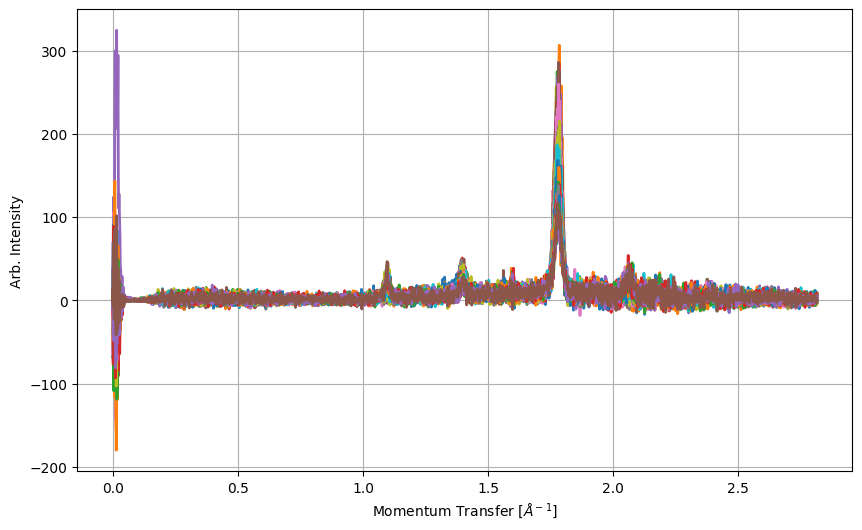

In [31]:
def spatial_set_init(direc, fname):
    with open(direc + '/' + fname, 'r') as f:
        flag = False
        headers = []
        for line in f:
            data = line.split()
            
            if flag:
                data = line.split('\t')
                for x in range(len(data)-1):
                    headers[x].append(float(data[x]))
                
            if bool(data) == True and data[0] == '#Bins':
                data = line.split('\t')
                for x in range(len(data)-1):
                    headers.append([data[x]])
                flag = True
        f.close()
    
    x_data = headers[1][1:]
    positions = []
    spectrum = []
    scan_list = []
    for x in range(3, len(data)-1):
        t = scan(x_data, headers[x][1:], 'energy', float(headers[x][0]))
        positions.append(float(headers[x][0]))
        scan_list.append(t)
    return spatial_set(scan_list)

                
q = spatial_set_init('/Users/anthonygironda/GitHub_Projects/EDX/EDX Processed Data', 'High pH BL 60C 2d.txt')
#'High pH BL 60C 6d.txt')
q.set_global_units('momentum')
q.quick_plot()

In [146]:


def file_list(directory, ftype):
    allflist = sorted(os.listdir(directory))
    flistlen = len(allflist)
    flist = []
    i = 0
    for x in range(flistlen):
        if allflist[x].endswith(str(ftype)):
            flist.append((allflist[x], i)); i +=1
    return flist

def text_unpacker

# class scan:
    
#     '''
#     ATTRIBUTES AND INITIALIZING
#     '''
    
#     def __init__(self, x_data, spectrum, units, position):
directory = '/Users/anthonygironda/GitHub_Projects/EDX/EDX Processed Data'
ftype = '.txt'
flist = (file_list(directory,ftype))



SyntaxError: invalid syntax (550185868.py, line 11)

In [ ]:
with open(sample1.get_name() +'.txt', 'w') as f:
    f.write(sample1.get_name())
    f.write('\n*********\n')
    f.write(header)
    for x in range(len(energy)):
        f.write(str(bins[x]))
        f.write('\t')
        f.write(str(round(energy[x],3)))
        f.write('\t')
        f.write(str((background[x])))
        f.write('\t')
        f.write(str(round(sample1.get_scan_list()[0].spectrum[x],3)))
        f.write('\t')
        f.write('\n')
    f.close()

In [ ]:
def txt_to_list(file):
    rows = []
    processedrows = []

    with open(file, 'r') as f:
        listofrows = f.read().split('\n')
        f.close()

    for i in range(len(listofrows)):
        rowcrawler = []
        rawrow = listofrows[i].split('\t')
        rowlength = len(rawrow)
        for j in range(rowlength):
            if rawrow[j] != '':
                rowcrawler.append(int(rawrow[j]))
        rows.append(rowcrawler)

    #rows is a list of lists, where each entry (i.e. rows[0] is a list reading pixels horizontally across camera
    #rows[5] is a list of each value of every pixel in the 6th row of the image
    #rows[x] has ditched the empty value at the end of each list. But there are 257 rows, not 256. So I need to check that
    #the last row is a real value and not junk

    for j in range(len(rows)):
        if bool(rows[j]):
            processedrows.append(rows[j])
        
    # For example, consider:
    #     1 2 3
    #     4 5 6
    #     7 8 9
    # as a 3x3 pixel camera image. processedrows[0] = [1, 2, 3], and processedrows[2] = [7, 8, 9]
    # processed processedrows[hz index][vt index] accesses that pixel, so processedrows[1][2] = 6
    
    return processedrows

(<Figure size 1000x600 with 1 Axes>,
 <AxesSubplot: xlabel='2θ', ylabel='Arb. Intensity'>)

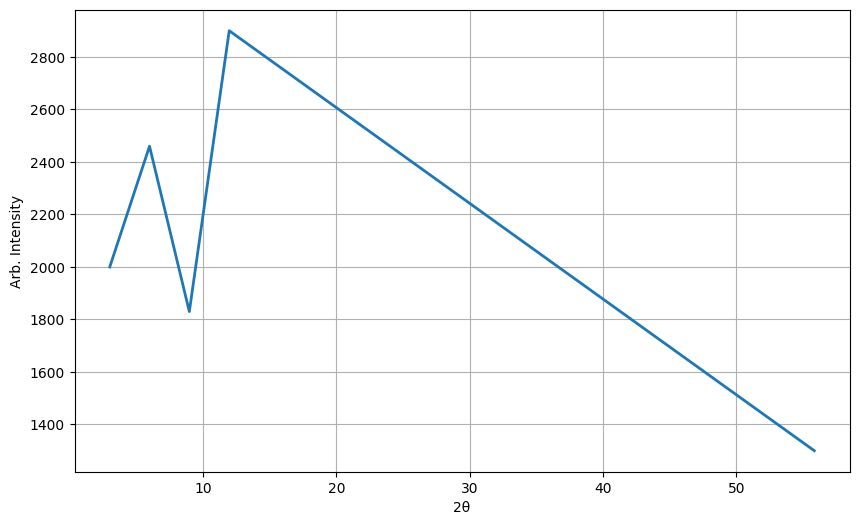

In [142]:
x=scan([10,20,30,40,180], [2000, 2460, 1830, 2900, 1300], 'energy', 1)
x.set_units('two theta')
x.quick_plot()

In [ ]:




class spatial_XRD_set:
    
    '''
    ATTRIBUTES AND INITIALIZING
    '''
    
    def __init__(self, bins):

In [21]:
directory = '/Users/anthonygironda/GitHub_Projects/EDX/EDX Processed Data'
ftype = '.txt'
display(file_list(directory,ftype))
exclude = ['Calcite Ref.txt', 'LaB6 Ref.txt']

['Calcite Ref.txt',
 'High pH BL 25C 14d.txt',
 'High pH BL 25C 4d.txt',
 'High pH BL 60C 2d.txt',
 'High pH BL 60C 4d.txt',
 'High pH BL 60C 6d.txt',
 'High pH BL Ref.txt',
 'High pH SF 25C 4d.txt',
 'High pH SF 25C 6d.txt',
 'High pH SF 25C 9d.txt',
 'High pH SF 60C 14d.txt',
 'High pH SF 60C 2d.txt',
 'High pH SF 60C 4d.txt',
 'High pH SF 60C 6d.txt',
 'High pH SF Ref.txt',
 'LaB6 Ref.txt',
 'Low pH SF 25C 14d.txt',
 'Low pH SF 25C 2d.txt',
 'Low pH SF 25C 4d.txt',
 'Low pH SF 25C 6d.txt',
 'Low pH SF 25C 9d.txt',
 'Low pH SF 60C 2d.txt',
 'Low pH SF 60C 4d.txt',
 'Low pH SF Ref.txt']

In [4]:
'''
INITIALIZATION HELPER FUNCTIONS
'''

def sample_instant_helper(df, scannum):
    scan_index = (df[df['ScanNum']==scannum].index.values)[0]
    pos_array = df['Position'][scan_index]
    spectra_set = df['Spectra'][scan_index]
    sampname = df['FullName'][scan_index]
    pH = df['pH'][scan_index]
    time = int(df['Days'][scan_index])
    temper = int(df['Temperature'][scan_index])
    atmosphere = df['Atmosphere'][scan_index]
    st_bool = df['SteelFiber'][scan_index]
    
    sample_edge = 4
    background_scans = [0,1,2]
    slist = []
    
    for q in range(len(pos_array)):
        radius = pos_array[q]
        spectra = spectra_set[q]
        slist.append(scan(spectra, radius))
        
    samp = sample(sampname, slist)
    
    samp.set_ph(pH)
    samp.set_steel_fiber(st_bool)
    samp.set_temp(temper)
    samp.set_atm(atmosphere)
    samp.set_time(time)
    samp.set_sample_edge(sample_edge)
    samp.set_scans_off_sample(background_scans)
    
    return samp


#When bool_pos_given_as_index is True, the pos instantiation variable is an index. Otherwise, when false,
#the pos instantiation variable is an actual position value, like -13.0 or 6.75. It also catches
#an edge case when the position array is empty, such as the calibration scan 1069. Things may behave funny when
#position arrays end in duplicates of 0s or any duplicates in general
def scan_instant_helper(df, scannum, pos, bool_pos_given_as_index):
    errorflag = True
    pos_i = None
    scan_index = (df[df['ScanNum']==scannum].index.values)[0]
    pos_array = df['Position'][scan_index]
    
    #edge case checker, if the position array of a given scan number is empty
    if ((pos == 0) and len(pos_array)==0):
        spectra_set = df['Spectra'][scan_index]
        spectra = spectra_set
        return scan(spectra, None)

    #If the bool is given as true, treat the pos variable like an index and not a value
    #Check first that the pos as an index is within the range of the scan's position array
    if bool_pos_given_as_index == True:
        if pos > (len(pos_array)-1): 
            return print('ERROR: Index is out of range of position array')
        else:
            pos_i = pos
            pos_value = abs(df['Position'][scan_index][pos_i])
            spectra_set = df['Spectra'][scan_index]
            spectra = spectra_set[pos_i]
            return scan(spectra, pos_value)
    
    #Otherwise, the bool was false and the pos variable was given as an actual position in the array
    #Check first that the pos value is actually in the array, and if so instantiate the scan with appropriate info
    else:
        for a in range(len(pos_array)):
            pos_val = pos_array[a]
            #This old logic in the 'or' statement was to catch the empty edge case, it should be unnecessary now
            if abs(pos_array[a])==abs(pos) or ((pos == 0) and len(pos_array)==0): 
                errorflag = False
                pos_i = a
                
        if errorflag == True: print('ERROR: Position is out of range')
        else:
            spectra_set = df['Spectra'][scan_index]
            spectra = spectra_set[pos_i]
            position_val = abs(df['Position'][scan_index][pos_i])
            return scan(spectra, position_val)
        

In [5]:
'''
OTHER IMPORTANT FUNCTIONS OUTSIDE OF CLASS METHODS
'''

#given x as a single float, int, or list; and a set of polynomial coeffecients, calculate and return the
#poly fit at the given x or list of converted values. Used to convert bin scale to energy

def poly_function(x, coeff):
    order = len(coeff) - 1
    pows = []
    for q in range(order + 1):
        pows.append(order - q)
    if type(x) == int or type(x) == float:
        y = 0
        for r in range(len(pows)):
            y = y + coeff[r] * np.power(x, pows[r])
        return y
    elif type(x) == list and (type(x[0]) == int or type(x[0]) == float):
        y_poly = []
        for s in range(len(x)):
            y = 0
            for t in range(len(pows)):
                y = y + coeff[t] * np.power(x[s], pows[t])
            y_poly.append(y/1000) 
        return y_poly
    else: return print('Error: Expected int, float, or list')

In [6]:
#Make a dataframe from the sample directory. Good to visualize data. You should 
#feed this dataframe to another function that will make an array of objects

def gen_spec_df(folder_dir, meta_dic):
    
    #initialize a df of the CSV sample/scan info.
    #This should probably be something I iron out with path (it'd be a '\' on PC) but it's fine for now
    raw_df = pd.read_csv(folder_dir + "/" + meta_dic)
    
    #get the hdf filename for every file in the directory
    files = []
    for x in os.listdir(folder_dir):
        if x.endswith(".hdf5"):
            files.append(x)
    
    #Add a column for filename in meta_df that is the same length of the meta_df
    edxname = [''] * len(raw_df.index)
    raw_df['FileName'] = edxname
    
    #Find each file in the meta_df by comparing scan number. Add file name 
    for y in range(len(files)):
        hdf_file = h5py.File(directory + files[y], 'r')
        for z in range(len(raw_df.index)):
            if raw_df['ScanNum'].values[z] == hdf_file.attrs['Scan Number']:
                raw_df['FileName'].values[z] = directory+files[y]
    
    #Add a column for EDX data arrays
    edxd = [''] * len(raw_df.index)
    raw_df['Spectra'] = edxd
    raw_df['Position'] = edxd
    
    #Scan through filenames and add position and spectra data arrays to df
    #If there's none, set those values equal to some string or warning
    for h in range(len(raw_df.index)):
        datahdf = h5py.File(raw_df['FileName'].values[h], 'r')
        positionflag = 'No Position Data (uh oh)'
        spectraflag = 'No Spectra Data (uh oh)'
        with h5py.File(raw_df['FileName'].values[h], 'r') as f:
            for x in range(len(f.keys())):
                if list(f.keys())[x] == '7bmb1:aero:m2.VAL':
                    raw_df['Position'].values[h] = f['7bmb1:aero:m2.VAL'][...]
                    positionflag = 'yep'
                if list(f.keys())[x] == 'dxpMercury:mca1.VAL':
                    raw_df['Spectra'].values[h] = f['dxpMercury:mca1.VAL'][...]
                    spectraflag = 'yep'
        if positionflag != 'yep':
            raw_df['Position'].values[h] = []
        if spectraflag != 'yep':
            raw_df['Spectra'].values[h] = []

    return raw_df


In [7]:
directory = '/Users/anthonygironda/Documents/MDA_Scans_Seidler/'
meta = '7bmb1_10.19.22_EDXindex.csv'

sample_df = gen_spec_df(directory, meta)
# sample_df.iloc[3]
# display(sample_df)

In [8]:
'''
DESCRIPTION:
Not much of a 'working class', it just helps set up the Sample class a bit easier. A scan is made
up of spectral data with an arbitrary x-axis, which are just bins.
'''

class scan:
    
    '''
    ATTRIBUTES AND INITIALIZING
    '''    
    
    def __init__(self, spectrum, position):
        self.spectrum = spectrum
        self.beam_position = position
    
    '''
    GETTER METHODS
    '''       
    
    def get_spectrum(self): return self.spectrum
    def get_beam_position(self): return self.beam_position
    def get_bins(self): return list(range(len(self.get_spectrum())))
    def get_num_of_points(self): return len(self.get_spectrum())

    '''
    VISUALIZATION
    '''
    
    def quick_plot(self, energy_bool):
        #Plot by bins
        fig, ax = plt.subplots(figsize = (10,6))
        ax.plot(self.get_bins(), self.get_spectrum(), linewidth=2.0)
        ax.set_xlabel('Bins')
        ax.set_ylabel('Counts')
        ax.grid(True)
        return (fig, ax)
    

In [8]:
class spatial_XRD_set:
    
    '''
    ATTRIBUTES AND INITIALIZING
    '''
    
    def __init__(self, scan_set, background_scans, ROI_edge, init_units, **kwargs):
        #Important all spectra arrays are of the same length. First step is to sanity check that.
        if self._check_dimensions(scan_set) != True: print('Warning: Arrays of different lengths')
        
        self.scan_list = scan_set
        self.scans_off_sample = background_scans
        self.sample_edge = ROI_edge
        
        self.const_lambda = Cu_ka
        self.const_angle = angle
        
        #attributes for plotting
        self.fit_degree = 3
        self.fit_features = [Mo_ka, Mo_kb, W_ka2, W_ka1, W_kb]
        self.fit_coeff = self._gen_fit_coeff()
        
        if (self._valid_unit(init_units)):
            self.units = init_units
        else:
            return 'Error, unit not recognized'
    
    def _valid_unit(self, unit):
        if (unit == 'bins' or unit == 'energy' or unit == 'momentum' or unit == 'two theta'):
            return True
        else:
            return False 
        
    def set_units(self, unit):
        old_unit = self.get_units()
        if (self._valid_unit(unit)):
            pass
        else:
            return
        


    def _unit_converter(self, old, new):
        
        
        
        
        #data_scale
        x_momentum = []
        x_energy = []
        x_two_theta = 
        
        for key, value in kwargs.items():
            if key == 'size': flag, size = True, value
        
        
        _gen_

SyntaxError: invalid syntax (991833351.py, line 39)

In [2]:
class sample:
    
    '''
    ATTRIBUTES AND INITIALIZING
    '''
    
    def __init__(self, sample_name, scan_set):
        #Important all spectra arrays are of the same length. First step is to sanity check that.
        if self._check_dimensions(scan_set) != True: print('Warning: Arrays of different lengths')
        
        #Instantiation attributes and fundamentals
        self.name = sample_name
        self.scan_list = scan_set

        #attributes intrinsic to formulation
        self.recipe_ph = None
        self.recipe_steel = None 
        
        #attributes related to aging
        self.aging_temp = None
        self.aging_atm = None
        self.aging_humidity = None
        self.aging_time = None        
        
        #attributes related to measurements
        self.scans_off_sample = None
        self.sample_edge = None
        
        #attributes for plotting
        self.fit_degree = 3
        self.fit_features = [Mo_ka, Mo_kb, W_ka2, W_ka1, W_kb]
        self.fit_coeff = self._gen_fit_coeff()
        self.units = 'Energy [keV]'
    
    '''
    SETTER METHODS
    '''
    
    #Formulation setters
    def set_ph(self, hi_low_string): self.recipe_ph = hi_low_string
    def set_steel_fiber(self, true_false): self.recipe_steel = true_false
    
    #Aging setters
    def set_temp(self, temperature): self.aging_temp = temperature
    def set_atm(self, atmosphere): self.aging_atm = atmosphere
    def set_humidity(self, rh): self.aging_humidity = rh
    def set_time(self, days): self.aging_time = days
    
    #Formulation + Aging setters catch-all
    def set_recipe_and_exposure(self, ph, steel_fiber, temp, atm, humidity, time):
        self.set_ph(ph) 
        self.set_steel_fiber(steel_fiber)
        self.set_temp(temp)
        self.set_humidity(humidity)
        self.set_time(time)

    #Measurement setters
    def set_scans_off_sample(self, back_list): self.scans_off_sample = back_list
    def set_sample_edge(self, edge_ind): self.sample_edge = edge_ind
    
    #Energy calibration / conversion setters
    def set_fit_degree(self, n): self.fit_degree = n
    def set_fit_features(self, list_of_tup): self.fit_features = list_of_tup
    def set_fit_coeff(self): self.fit_coeff = self._gen_fit_coeff()
    def set_units(self, unit): self.units = units

    '''
    GETTER METHODS
    '''

    #Basic attributes and quick calculation getters
    def get_name(self): return self.name
    def get_scan_list(self): return self.scan_list
    def get_num_of_scans(self): return len(self.get_scan_list())
    def get_bins(self): return self.get_scan_list()[0].get_bins()
    def get_num_of_points(self): return len(self.get_bins())
    def get_scan(self, index): return (self.get_scan_list()[index])
    def get_spectrum(self, index): return (self.get_scan(index).get_spectrum())
    def get_positions(self):
        scan_pos = []
        for a in range(self.get_num_of_scans()):
            if (self.scan_list[a]).beam_position == None: scan_pos.append(0)
            else: scan_pos.append((self.scan_list[a]).beam_position)
        return scan_pos
    
    #Attributes related to chemistry and aging
    def get_ph(self): return (self.recipe_ph)
    def get_steel_fiber(self): return (self.recipe_steel)    
    def get_temp(self): return (self.aging_temp) 
    def get_atm(self): return (self.aging_atm)
    def get_humidity(self): return (self.aging_humidity)
    def get_time(self): return (self.aging_time)
    
    #Measurement / data processing related getters
    def get_units(self): return self.units
    def get_energy(self): return poly_function(self.get_bins(), self.get_fit_coeff())
    def get_scans_off_sample(self): return self.scans_off_sample
    def get_sample_edge(self): return self.sample_edge
    def get_avg_background_spectrum(self): return self._gen_background()
    def get_fit_degree(self): return self.fit_degree
    def get_fit_features(self): return self.fit_features
    def get_fit_coeff(self): self.fit_coeff = self._gen_fit_coeff(); return self.fit_coeff

    #Spit out the important stuff
    def get_attr(self):
        attr_names = ['Name', 'Number of Scans', 'Positions', 'Points per Scan', 'Sample Edge', 'Scans Off Sample',
                      'Conversion Features', 'Degree of Fit', 'Fit Coeffecients', 'pH', 'Steel Fiber', 'Aging Temp.',
                      'Aging Atm.', 'Aging Humidity', 'Aging Time']
        attr_prop = [self.get_name(), self.get_num_of_scans(), self.get_positions(), self.get_num_of_points(),
                     self.get_sample_edge(), self.get_scans_off_sample(), self.get_fit_features(), self.get_fit_degree(),
                     self.get_fit_coeff(), self.get_ph(), self.get_steel_fiber(), self.get_temp(), self.get_atm(), 
                     self.get_humidity(), self.get_time()]
        bigstring = ''
        if len(attr_prop) == len(attr_names):
            for x in range(len(attr_names)):
                bigstring = bigstring + (attr_names[x])
                bigstring = bigstring + (': ')
                bigstring = bigstring + (str(attr_prop[x]))
                bigstring = bigstring + ('\n')
            return print(bigstring)
        
    '''
    INTERNAL METHODS
    '''
    
    #Find the specified scan indices that were off the sample and return an average spectrum of them
    def _gen_background(self):
        avg_background_spectra = []
        spectra_points = self.get_num_of_points()
        i_list = self.get_scans_off_sample()
        if i_list is None: return [0]*(spectra_points)
        num_of_scans = len(i_list)
        for x in range(spectra_points):
            avg_background = 0
            for y in range(num_of_scans):
                avg_background = avg_background + self.get_spectrum(i_list[y])[x]
            avg_background_spectra.append(avg_background / num_of_scans)
        return avg_background_spectra
    
    #Returns list of polynomial coeffecients, highest degree first. Needs degree and set of xy points
    def _gen_fit_coeff(self):
        return np.polyfit([i[0] for i in self.get_fit_features()], 
                                      [i[1] for i in self.get_fit_features()], 
                                      self.get_fit_degree())    
    
    #Called during initialization. Make sure every scan in the sample's list is the same length
    def _check_dimensions(self, scan_list):
        same_length = True
        prev_length = scan_list[0].get_num_of_points()
        for c in range(len(scan_list)):
            if c > 1:
                curr_length = scan_list[c].get_num_of_points()
                if curr_length != prev_length:
                    same_length = False
                prev_length = curr_length
        return same_length
    
    def _conv_bins_to_energy(self, bin_array): 
        return poly_function(bin_array, self.get_fit_coeff())
    
    def _convert_units(self, from_unit, to_unit):
        return
    
    #Given a value in kev, find the nearest index / bin closest to the value
    def _find_nearest_index(self, energy_kev):
        en_array = self.get_energy()
        for d in range(len(en_array)):
            if en_array[d] > energy_kev:
                above_val_delta = en_array[d] - energy_kev
                below_val_delta = energy_kev - en_array[d-1]
                if below_val_delta < above_val_delta: return (d-1)
                else: return d
        return print("Error: _find_nearest_index() didn't work")
    
    #given a spectra array, limits in kev, and an interval, return an energy and spectra array that is an
    #intervalled selection of the whole. i.e. in:[10,5,8,32,4,2,7] -> interval 2 -> out:[10,8,32,2]
    def _interval_spectral_slice(self, spec_array, bounds, interval):
        bin_bounds = self._find_nearest_index(bounds[0]) , self._find_nearest_index(bounds[1])
        spec_array_slice = spec_array[bin_bounds[0]:bin_bounds[1]]
        en_data = self._conv_bins_to_energy(list(range(bin_bounds[0],bin_bounds[1])))
        loopcount = bin_bounds[0]
        index = 0
        interval_en = []
        interval_spec = []
        for p in range(bin_bounds[0], bin_bounds[1]):
            if p == loopcount:
                interval_en.append(en_data[index])
                interval_spec.append(spec_array_slice[index])
                loopcount = loopcount + interval
                index = index + interval
        return interval_en, interval_spec
    
#     def _off_sample_background_subtractor(self): return
                                          
#     def _linear_sample_background_subtractor(self): return

#     def _trapezoid_rule_numerical_integral(self, bounds):
#         return
    
#     def _back(self): 
#         return
        
    '''
    DATA PIPELINE: BACKGROUND SELECTION, REMOVAL, AND PEAK INTEGRATION; FOR CLARITY AND VALIDATION
    '''
    
    def peak_integral_pipeline(self, peakbounds, lback, uback, interval):
        
        #STEP 0: Make subplots and broad axis labels, use interval to determine the scans to plot
        fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(9, 14),layout="constrained")
        fig.suptitle(self.get_name())
        domain_offset = 2
        for x in range(3):
            for y in range(2):
                axs[x,y].set_xlim(lback[0] - domain_offset, uback[1] + domain_offset)
                axs[x,y].set_ylim(0, 350)
                axs[x,y].set_xlabel('Energy [keV]')
                axs[x,y].set_ylabel('Counts')

        x_data = self.get_energy()
        start_i = self.get_sample_edge()
        total_scans = self.get_num_of_scans()
        interval_scans = []
        sample_pos_set = []

        for q in range(total_scans):
            if q == start_i:
                interval_scans.append(self.get_spectrum(q))
                sample_pos_set.append(self.get_scan(q).get_beam_position())
                start_i = start_i + interval
        scan_num = len(interval_scans)
        
        
        #STEP 1: Display the spectra, plot only every 1st, 2nd, or 3rd scan etc. given by interval
        for q in range(scan_num):
            axs[0,0].plot(x_data, interval_scans[q], linewidth = 0.5, color = 'b')
        axs[0,0].set_title('Raw Spectra')

        
        #STEP 2: Display the spectra and show the avg off-sample background
        off_sample_background = self.get_avg_background_spectrum()
        axs[0,1].plot(x_data, off_sample_background, linewidth = 0.8, color = 'r')
        for q in range(scan_num):
            axs[0,1].plot(x_data, interval_scans[q], linewidth = 0.5, color = 'b')
        axs[0,1].set_title('Unadjusted Peak Regime and Off-Sample Background Spectrum')
        
        
        #STEP 3: Display the off-sample background subtracted spectra
        adj_spec_set = []
        for q in range(scan_num):
            adj_spec = np.subtract(interval_scans[q], off_sample_background)
            adj_spec_set.append(adj_spec)
            axs[1,0].plot(x_data, adj_spec, linewidth = 0.5, color = 'b')
        axs[1,0].set_title('Off-Sample Background Subtracted')
        
        
        #STEP 4: Highlight selected low and high background ranges for linear background fit
        axs[1,1].axvspan(lback[0], lback[1], alpha=0.5, color='yellow')
        axs[1,1].axvspan(uback[0], uback[1], alpha=0.5, color='yellow')
        scatter_spacing = 5
        low_scat_x, low_scat_y = self._interval_spectral_slice(adj_spec_set[0], lback, scatter_spacing)
        hi_scat_x, hi_scat_y = self._interval_spectral_slice(adj_spec_set[0], uback, scatter_spacing)
        scat_x = low_scat_x + hi_scat_x
        scat_y = low_scat_y + hi_scat_y
        axs[1,1].scatter(scat_x, scat_y, marker = 'x', color = 'r', zorder = 2)
        for q in range(scan_num):
            axs[1,1].plot(x_data, adj_spec_set[q], linewidth = 0.5, color = 'b', zorder = 1)
        axs[1,1].set_title('Further Background Selection')
        
        
        #STEP 5: Fit example line through lower and upper background sections
        coeff_set = []
        degree = 2        
        for f in range(scan_num):
            low_back_xy = self._interval_spectral_slice(adj_spec_set[f], lback, 1)
            hi_back_xy = self._interval_spectral_slice(adj_spec_set[f], uback, 1)
            back_x = low_back_xy[0] + hi_back_xy[0]
            back_y = low_back_xy[1] + hi_back_xy[1]
            coeff_set.append(np.polyfit(back_x, back_y, degree))
        axs[2,0].plot(x_data, np.poly1d(coeff_set[0])(x_data), linewidth = 1, color = 'r', zorder = 2)
        for q in range(scan_num):
            axs[2,0].plot(x_data, adj_spec_set[q], linewidth = 0.5, color = 'b', zorder = 1)
            # axs[2,0].plot(x_data, np.poly1d(coeff_set[q])(x_data), linewidth = 0.5, color = 'r', zorder = 2)
        axs[2,0].set_title('Poly Fit (Degree: ' + str(degree) +') of Remaining Background')
        
        
        #STEP 6: Show final peak after background subtractions
        processed_spectral_set = []
        for q in range(scan_num):
            processed_y = np.subtract(adj_spec_set[q], np.poly1d(coeff_set[q])(x_data))
            processed_spectral_set.append(processed_y)
            axs[2,1].plot(x_data, processed_y, linewidth = 0.5, color = 'b')
        axs[2,1].set_title('Fully Processed Spectral Peak')

            
        #STEP 7: Show final peak bounds and center
        for q in range(scan_num):
            axs[3,0].plot(x_data, processed_spectral_set[q], linewidth = 0.8, color = 'b')
        axs[3,0].set_xlim(peakbounds[0]-2, peakbounds[1]+2)
        axs[3,0].set_ylim(0,350)
        axs[3,0].axvspan(peakbounds[0], peakbounds[1], alpha=0.5, color='green')
        center = (peakbounds[0]+peakbounds[1])/2
        axs[3,0].axvline(x = center, color = 'red', label = 'Peak Bounds Center')
        axs[3,0].set_xlabel('Energy [keV]')
        axs[3,0].set_ylabel('Counts')
        axs[3,0].set_title('Peak Integral Bounds and Center')

        
        #STEP 8: Peak area integral as a function of R
        lower_i = self._find_nearest_index(peakbounds[0])
        upper_i = self._find_nearest_index(peakbounds[1])
        integrate_peak = []
        for k in range(scan_num):
            peak_area = 0.0
            for j in range(lower_i, upper_i):
                avg = (processed_spectral_set[k][j] + processed_spectral_set[k][j+1])/2
                area = avg * (x_data[j+1] - x_data[j])
                peak_area = peak_area + area
            integrate_peak.append(peak_area)
        axs[3,1].plot(sample_pos_set, integrate_peak, linewidth = 1)
        axs[3,1].scatter(sample_pos_set, integrate_peak, marker = '.', color = 'b', zorder = 2)
        axs[3,1].set_xlabel('Distance from Center [mm]')
        axs[3,1].set_ylabel('Peak Area')
        axs[3,1].set_title('Peak Area as a Function of Position')
        
        return fig, axs


In [3]:
'''
Mo W FOIL REFERENCE -- DOES THE ENERGY SCALE MAKE SENSE?
'''

background_scans = [scan_instant_helper(sample_df, 1093, 0, True),
                    scan_instant_helper(sample_df, 1093, 0, True),
                    scan_instant_helper(sample_df, 1093, 0, True)]
mo_w_ref_scan = scan_instant_helper(sample_df, 1069, 0, False)
scan_list = background_scans + [mo_w_ref_scan]
mo_w = sample('Mo W Foil Energy Conversion Reference Scan', scan_list)
mo_w.set_sample_edge(3)
mo_w.set_scans_off_sample([0,1,2])

peak = (82.7, 85)
lower_back = (77, 81)
upper_back = (88, 92)
plot_every_other = 0

unadj_peak_xlim = (0, 100)

x = mo_w.peak_integral_pipeline(peak, lower_back, upper_back, plot_every_other)
x[0].delaxes(x[1][1,0])
x[0].delaxes(x[1][1,1])
x[0].delaxes(x[1][2,0])
x[0].delaxes(x[1][2,1])
x[0].delaxes(x[1][3,0])
x[0].delaxes(x[1][3,1])


x[1][0,0].set_xlim(unadj_peak_xlim[0],unadj_peak_xlim[1])
x[1][0,1].set_xlim(unadj_peak_xlim[0],unadj_peak_xlim[1])
x[1][0,0].set_ylim(0,1300)
x[1][0,1].set_ylim(0,1300)


NameError: name 'scan_instant_helper' is not defined

In [ ]:
'''
GREAT -NOW CAN WE GET FROM AN ENERGY SCALE TO A TWO-THETA SCALE SO I CAN COMPARE DATA TO DIFFRACTION PATTERNS.
SCAN 1070 WAS LAB6 -- A COMMON CALIBRATION STANDARD. IF I MATCH UP LAB6 EDX FEATURES TO DIFFRACTION FEATURES, 
I SHOULD BE ABLE TO CONVERT THE SCALE FOR THE OTHER SCANS.
'''
lab6_scan = scan_instant_helper(sample_df, 1070, 0, True)
background_scans = [scan_instant_helper(sample_df, 1093, 0, True),
                    scan_instant_helper(sample_df, 1093, 0, True),
                    scan_instant_helper(sample_df, 1093, 0, True)]
lab6 = sample('LaB6 EDX/Diffraction Pattern Conversion Reference Scan', background_scans + [lab6_scan])
# fig, ax = lab6_scan.quick_plot(False)
# # ax.set_xlim(400,1500)
# ax.set_ylim(0, 1000)

lab6.set_sample_edge(3)
lab6.set_scans_off_sample([0,1,2])

peak = (82.7, 85)
lower_back = (77, 81)
upper_back = (88, 92)
plot_every_other = 0

unadj_peak_xlim = (0, 100)

x = lab6.peak_integral_pipeline(peak, lower_back, upper_back, plot_every_other)
x[0].delaxes(x[1][1,0])
x[0].delaxes(x[1][1,1])
x[0].delaxes(x[1][2,0])
x[0].delaxes(x[1][2,1])
x[0].delaxes(x[1][3,0])
x[0].delaxes(x[1][3,1])


x[1][0,0].set_xlim(10, 120)
x[1][0,1].set_xlim(10, 120)
x[1][0,0].set_ylim(0,1300)
x[1][0,1].set_ylim(0,1300)




In [4]:
'''
THE PROCESS -- HOW BACKGROUND SUBTRACTION AND PEAK INTEGRATION WORK
SAMPLE -- CARBONATED, HIGH PH, NO STEEL
SELECTED PEAK -- NOT CALCITE
'''
example = sample_instant_helper(sample_df, 1103)

peak = (82, 86)
lower_back = (77, 81)
upper_back = (88, 92)

plot_every_other = 1
unadj_peak_xlim = (50, 110)

# example.get_attr()

x = example.peak_integral_pipeline(peak, lower_back, upper_back, plot_every_other)
x[1][0,0].set_xlim(unadj_peak_xlim[0],unadj_peak_xlim[1])
# x[1][0,1].set_xlim(unadj_peak_xlim[0],unadj_peak_xlim[1])

NameError: name 'sample_instant_helper' is not defined

In [5]:
'''
CALCITE REFERENCE SAMPLE -- WHERE ARE MY PEAKS? ANSWER: AROUND 98 keV
'''

background_scans = [scan_instant_helper(sample_df, 1093, 0, True),
                    scan_instant_helper(sample_df, 1093, 0, True),
                    scan_instant_helper(sample_df, 1093, 0, True)]
calcite_scan = [scan_instant_helper(sample_df, 1071, 0, False)]
scan_list = background_scans + calcite_scan
calcite = sample('Calcite Reference', scan_list)
calcite.set_sample_edge(3)
calcite.set_scans_off_sample([0,1,2])


peak = (97, 99)
lower_back = (80, 90)
upper_back = (105, 120)

plot_every_other = 0
# unadj_peak_xlim = (90, 110)
unadj_peak_xlim = (0, 130)

x = calcite.peak_integral_pipeline(peak, lower_back, upper_back, plot_every_other)
x[0].delaxes(x[1][1,0])
x[0].delaxes(x[1][1,1])
x[0].delaxes(x[1][2,0])
x[0].delaxes(x[1][2,1])
x[0].delaxes(x[1][3,0])
x[0].delaxes(x[1][3,1])


x[1][0,0].set_xlim(unadj_peak_xlim[0],unadj_peak_xlim[1])
# x[1][0,1].set_xlim(unadj_peak_xlim[0],unadj_peak_xlim[1])

NameError: name 'scan_instant_helper' is not defined

In [6]:
'''
SAMPLE -- NO STEEL, HIGH PH, 60C, 6 DAYS
PEAK -- CALCITE, ~97 keV
'''
example = sample_instant_helper(sample_df, 1103)

peak = (95.5, 99)
lower_back = (87, 95)
upper_back = (100, 110)

# example.get_attr()

plot_every_other = 1
unadj_peak_xlim = (60, 120)

x = example.peak_integral_pipeline(peak, lower_back, upper_back, plot_every_other)
x[1][0,0].set_xlim(unadj_peak_xlim[0],unadj_peak_xlim[1])


NameError: name 'sample_instant_helper' is not defined

Name: High pH BL 60C 6d
Number of Scans: 29
Positions: [-13.0, -12.75, -12.5, -12.25, -12.0, -11.75, -11.5, -11.25, -11.0, -10.75, -10.5, -10.25, -10.0, -9.75, -9.5, -9.25, -9.0, -8.75, -8.5, -8.25, -8.0, -7.75, -7.5, -7.25, -7.0, -6.75, -6.5, -6.25, -6.0]
Points per Scan: 2048
Sample Edge: 4
Scans Off Sample: [0, 1, 2]
Conversion Features: [(275, 17444.3), (309, 19608.3), (913, 57981.7), (934, 59318.24), (1058, 67244.3)]
Degree of Fit: 3
Fit Coeffecients: [ 8.59183418e-07 -1.48200024e-03  6.43003351e+01 -1.44206885e+02]
pH: High
Steel Fiber: False
Aging Temp.: 60
Aging Atm.: 100% CO2
Aging Humidity: None
Aging Time: 6



(40.0, 100.0)

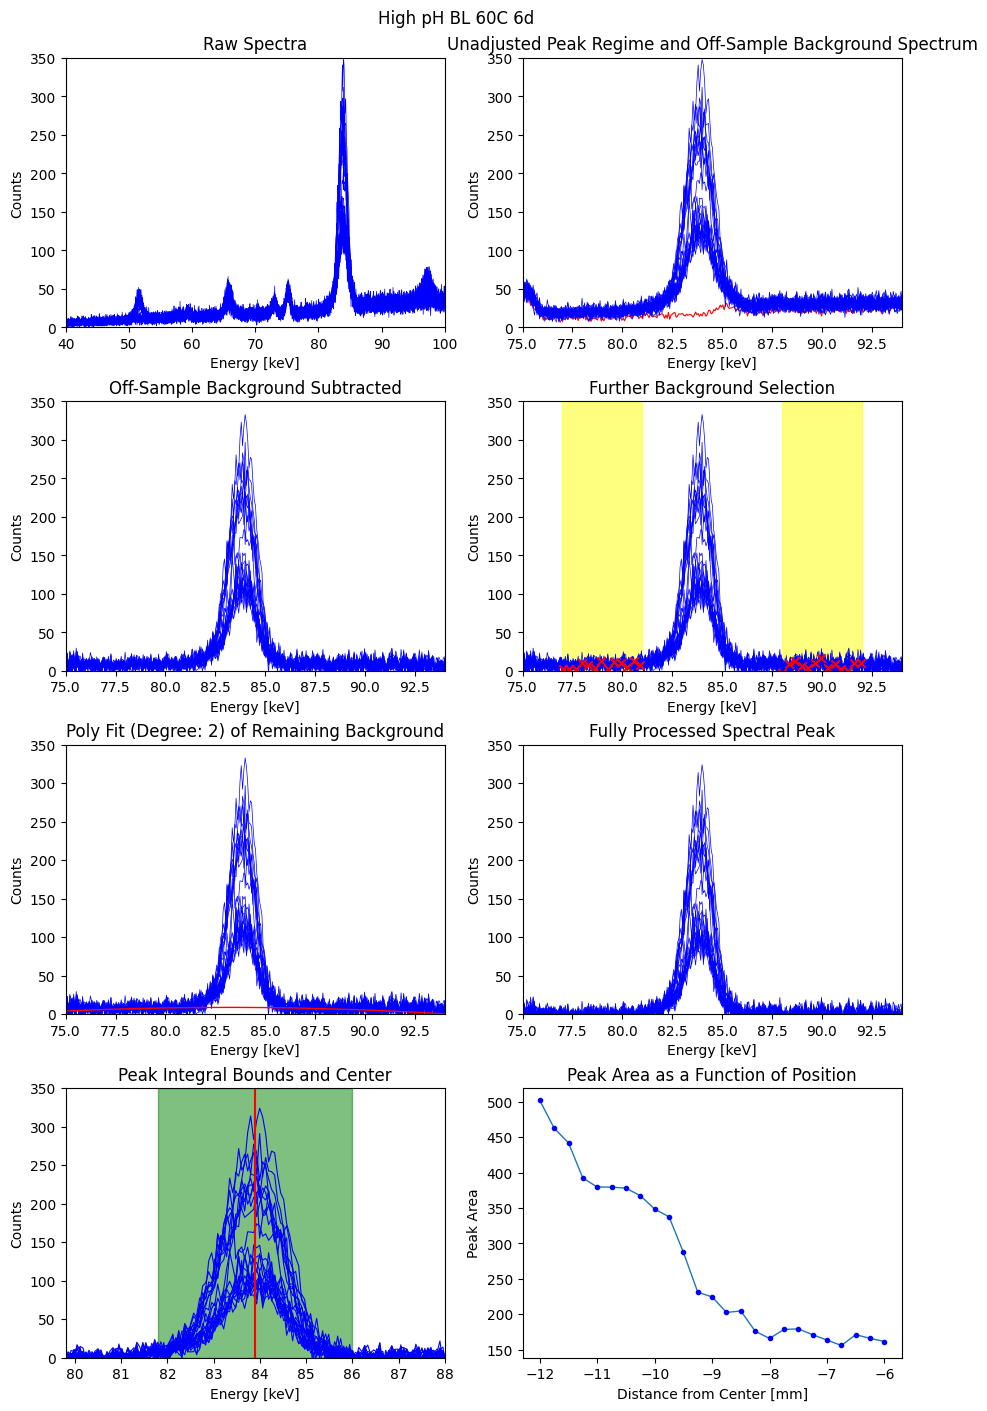

In [13]:
test = sample_instant_helper(sample_df, 1103)

peak = (81.8, 86)
lower_back = (77, 81)
upper_back = (88, 92)
plot_every_other = 1
unadj_peak_xlim = (40, 100)

test.get_attr()

x = test.peak_integral_pipeline(peak, lower_back, upper_back, plot_every_other)
x[1][0,0].set_xlim(unadj_peak_xlim[0],unadj_peak_xlim[1])



Name: High pH BL 60C 6d
Number of Scans: 29
Positions: [-13.0, -12.75, -12.5, -12.25, -12.0, -11.75, -11.5, -11.25, -11.0, -10.75, -10.5, -10.25, -10.0, -9.75, -9.5, -9.25, -9.0, -8.75, -8.5, -8.25, -8.0, -7.75, -7.5, -7.25, -7.0, -6.75, -6.5, -6.25, -6.0]
Points per Scan: 2048
Sample Edge: 4
Scans Off Sample: [0, 1, 2]
Conversion Features: [(275, 17444.3), (309, 19608.3), (913, 57981.7), (934, 59318.24), (1058, 67244.3)]
Degree of Fit: 3
Fit Coeffecients: [ 8.59183418e-07 -1.48200024e-03  6.43003351e+01 -1.44206885e+02]
pH: High
Steel Fiber: False
Aging Temp.: 60
Aging Atm.: 100% CO2
Aging Humidity: None
Aging Time: 6



(15.0, 20.0)

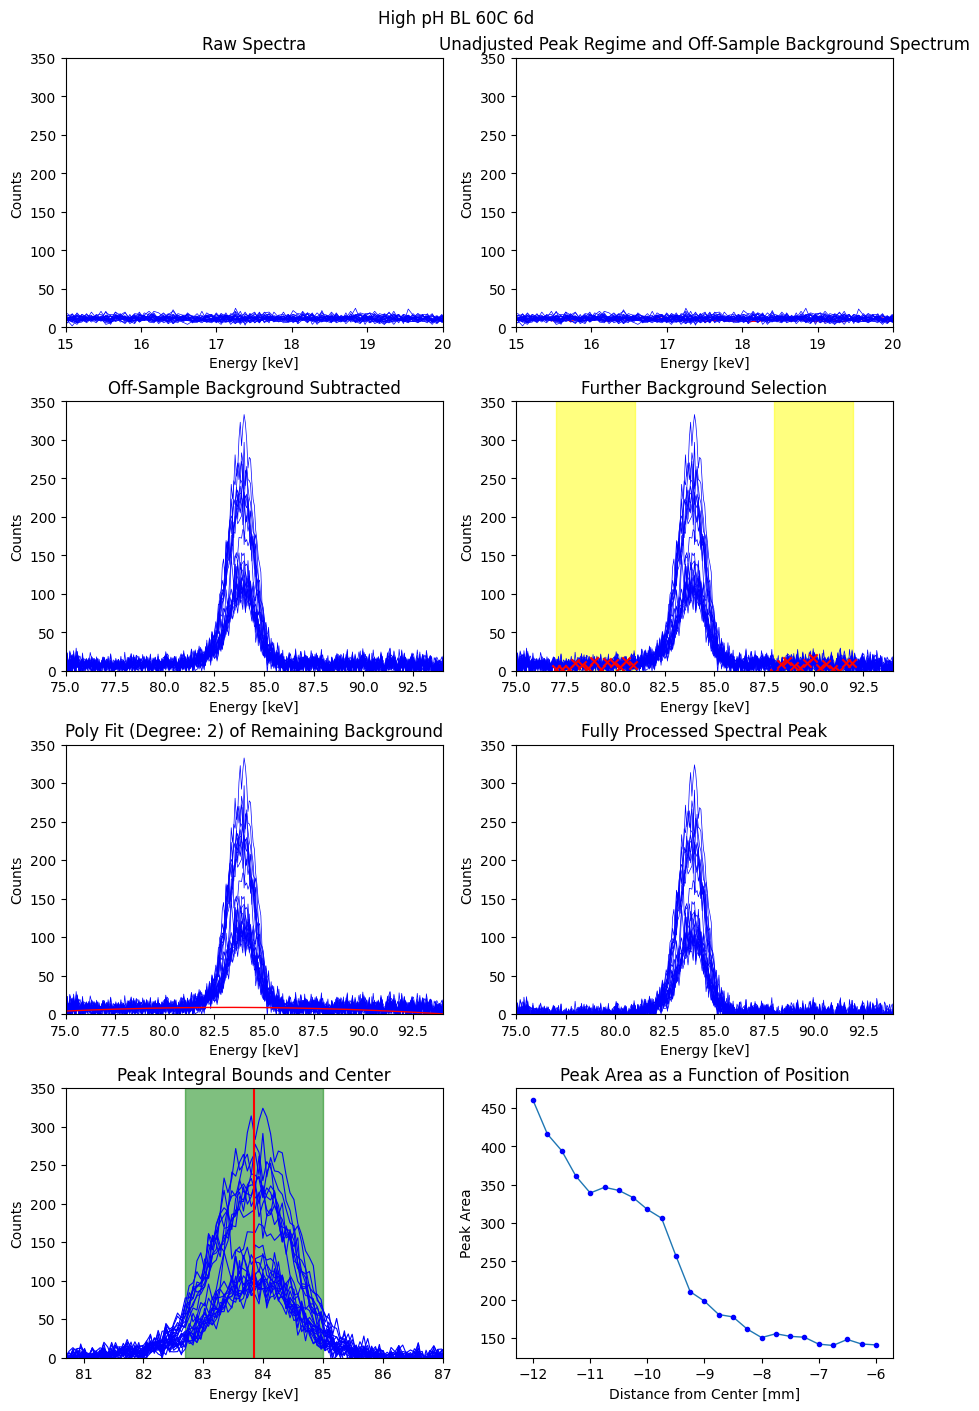

In [14]:
test = sample_instant_helper(sample_df, 1103)

peak = (82.7, 85)
lower_back = (77, 81)
upper_back = (88, 92)
plot_every_other = 1
unadj_peak_xlim = (15, 20)

test.get_attr()

x = test.peak_integral_pipeline(peak, lower_back, upper_back, plot_every_other)
x[1][0,0].set_xlim(unadj_peak_xlim[0],unadj_peak_xlim[1])
x[1][0,1].set_xlim(unadj_peak_xlim[0],unadj_peak_xlim[1])

In [15]:
HS250 = sample_instant_helper(sample_df, 1101)
HS250.set_fit_degree(0)
HS250.get_fit_coeff()

array([44319.368])

In [16]:
HS250 = sample_instant_helper(sample_df, 1093)

peak = (83.5, 84)
lower_back = (78, 80)
upper_back = (88, 90)
plot_every_other = 8

HS250.peak_integral(peak, lower_back, upper_back, plot_every_other)
HS250._interval_spectral_slice(HS250.scans[0].spectra, (78,80), 1)

print(x)
print(y)

print(len(xadj))
print(len(yadj))

AttributeError: 'sample' object has no attribute 'peak_integral'

In [ ]:
HS250 = sample_instant_helper(sample_df, 1093)
# x = HS250.quick_integral(83, 84, 4, True)
HS250.get_sample_edge()

peak = (83.5, 84)
lower_back = (78, 80)
upper_back = (88, 90)
plot_every_other = 5

HS250.peak_integral(peak, lower_back, upper_back, plot_every_other)

# HS602.get_attr()

# HS602.quick_integral_en((81,85), 0)
# HS602.set_off_sample_scans([0,1,2])
# HS602.set_off_sample_background()
# x = HS602.get_off_sample_background()

# plot, axis = plt.subplots(figsize = (8,5))
# axis.plot(HS602.get_energy(),HS602.get_off_sample_background(), alpha = 0.5)
# axis.plot(HS602.get_energy(), HS602.scans[10].spectra, alpha = 0.5)
# axis.set_ylim(0,200)
# axis.set_xlim(40, 120)


In [ ]:
class series:
    def __init__(self, sample_list):
        self.list = sample_list
        
    def peak_integral_en(self, limits, index_start):
        fig_list = []
        for q in range(len(self.list)):
            smpl = self.list[q]
            smpl.quick_integral_en(limits, index_start)
            
    def peak_integral_en2(self, limits):
        fig_list = []
        for q in range(len(self.list)):
            smpl = self.list[q]
            smpl.quick_integral_en2(limits)
            
    def peak_integral_mosaic(self, limits, index_start):
        fig_list = []
        for q in range(len(self.list)):
            smpl = self.list[q]
            smpl.quick_integral_en(limits, index_start)
            

In [ ]:
HS602 = sample_instant_helper(sample_df, 1091)
HS604 = sample_instant_helper(sample_df, 1092)
HS606 = sample_instant_helper(sample_df, 1083)
HS6014= sample_instant_helper(sample_df, 1087)

HS250 = sample_instant_helper(sample_df, 1093)
HS254 = sample_instant_helper(sample_df, 1094)
HS256 = sample_instant_helper(sample_df, 1089)
HS259 = sample_instant_helper(sample_df, 1088)

HB602 = sample_instant_helper(sample_df, 1105)
HB604 = sample_instant_helper(sample_df, 1104)
HB606 = sample_instant_helper(sample_df, 1103)

HB250 = sample_instant_helper(sample_df, 1108)
HB254 = sample_instant_helper(sample_df, 1107)
HB2514= sample_instant_helper(sample_df, 1106)

LS602 = sample_instant_helper(sample_df, 1096)
LS604 = sample_instant_helper(sample_df, 1095)

LS250 = sample_instant_helper(sample_df, 1102)
LS252 = sample_instant_helper(sample_df, 1101)
LS254 = sample_instant_helper(sample_df, 1100)
LS256 = sample_instant_helper(sample_df, 1097)
LS259 = sample_instant_helper(sample_df, 1098)
LS2514= sample_instant_helper(sample_df, 1099)

high_base_60 = series([HB602,HB604,HB606])
high_steel_60 = series([HS602,HS604,HS606,HS6014])
high_base_25 = series([HB250, HB254, HB2514])
high_steel_25 = series([HS250,HS254,HS256,HS259])

low_steel_60 = series([LS602, LS604])
low_steel_25 = series([LS250, LS252, LS254, LS256, LS259, LS2514])

full_set = series([HB250, HB254, HB2514, HS250,HS254,HS256,HS259, HB602,HB604,HB606, HS602,HS604,HS606,HS6014, 
                   LS250, LS252, LS254, LS256, LS259, LS2514, LS602, LS604]) 

high_steel_60.peak_integral_en2((82.5,88))
# len(low_steel_60.list[0].background_spectra)

# full_set.peak_integral_en((78,88),0)

calc_scan = scan_instant_helper(sample_df, 1071, 0, False)
calcite = sample('Calcite (CaCO3) Reference', [calc_scan]) 

# LS254.get_attr()

# a = HB2514.quick_plot()
# a[1].set_xlim(1200,1400)
# a[1].set_ylim(0,300)

# HB2514.quick_integral((1200,1400),2)
plt.close()

# HS602.quick_integral_en((82,86), 0)

In [ ]:
s1 = HB2514.custom_stack(i = (28), interval = 10, xlim = (10.5, 7.20))
stackp = HB2514.stack(120)
stackp[1].set_xlim(1000, 1700)
stackp[1].set_ylim(250, 3000)
b = HB2514.quick_integral((1280, 1350), 4)

In [ ]:
def energy_bin_linearity(bounds):
    cal_feat_list = [Mo_ka, Mo_kb, W_ka2, W_ka1, W_kb]
    bins = list(range(2048))
    poly_orders = None
    if type(bounds) == int:
        if bounds == 0: poly_orders = (1,2)
        else: poly_orders = (1, abs(bounds) + 1)
    elif type(bounds) == tuple:
        t1, t2 = abs(bounds[0]), abs(bounds[1])
        if type(t1) == int and type(t2)== int:
            if t1 == t2: poly_orders = (t1, t1 + 1)
            elif t1 > t2: poly_orders = (t2, t1 + 1)
            else: poly_orders = (t1, t2 + 1)
        else: return print('Error: Expected int tuple')
    if poly_orders == None:
        return print('Error: Expected int or int tuple')
    
    
    fig = plt.figure(figsize=(10, 8), layout="constrained")
    spec = fig.add_gridspec(3, 3)
    ax0 = fig.add_subplot(spec[0, :])
    
    moka = fig.add_subplot(spec[1, 0], title = 'Mo Ka')
    mokb = fig.add_subplot(spec[1, 1], title = 'Mo Kb')
    
    wka2 = fig.add_subplot(spec[2,0], title = 'W Ka2')
    wka1 = fig.add_subplot(spec[2,1], title = 'W Ka1')
    wkb = fig.add_subplot(spec[2,2], title = 'W Kb')
    
    ax = [ax0, moka, mokb, wka2, wka1, wkb]
    l = len(ax)
    
    fig.suptitle('Fit Assessment of Energy Scale Conversion by Fitted Polynomial Degree')

    for a in range(l):
        ax[a].set_xlabel('Bin Number')
        ax[a].set_ylabel('Energy [keV]')
        ax[a].grid(True)
        
        if a > 0:
            calbin = (cal_feat_list[a-1])[0]
            calen = (cal_feat_list[a-1])[1] / 1000
            ax[a].set_xlim(calbin -1, calbin + 1)
            ax[a].set_ylim(calen - .03, calen + .03)
            ax[a].set_xticks([calbin -1, calbin, calbin +1])


    poly_fit = []
    for n in range(poly_orders[0], poly_orders[1]):
        coeff = np.polyfit([i[0] for i in cal_feat_list], [i[1] for i in cal_feat_list], n)
        energy = poly_function(bins, coeff)
        ax[0].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))
        ax[1].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))
        ax[2].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))
        ax[3].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))
        ax[4].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))
        ax[5].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))

    ax[0].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    ax[1].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    ax[2].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    ax[3].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    ax[4].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    ax[5].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    
    
    
    ax[0].legend()
    plt.show()
    
    return(poly_orders)

energy_bin_linearity(4)

In [ ]:

      
    '''
    QUICK VISUALIZATIONS
    '''
    
    def quick_plot(self, energy_bool):
        fig, ax = plt.subplots()
        ax.set_ylim(0,500)
        if energy_bool == True: 
            x_data = self.get_energy()
            ax.set_xlim(55,90)
            ax.set_xlabel('Energy [keV]')
        else: 
            x_data = self.get_bins()
            ax.set_xlim(900, 1500)
            ax.set_xlabel('Bin Number')
        scan_num = self.get_num_of_scans()
        for g in range(scan_num):
            ax.plot(x_data, (self.scans[g]).spectra, linewidth=0.5, color = 'b')
        ax.set_ylabel('Counts')
        ax.grid(True)
        ax.set_title(str(self.name) + " EDXRD Spectra")
        return (fig, ax)
        
    def quick_integral(self, lbound, ubound, index_start, energy_bool):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
        num_of_scans = self.get_num_of_scans()
        position_array = self.get_positions()[index_start:num_of_scans]
        ax1.set_xlim(lbound, ubound)
        if energy_bool == True: 
            x_data = self.get_energy()
            ax1.set_xlabel('Energy [keV]')
        else: 
            x_data = self.get_bins()
            ax1.set_xlabel('Bin Number')
        ax2.set_xlabel('Distance from Center [mm]')
        integrate_peak = []
        peak_max = 0.0
        for g in range(num_of_scans):
            if g >= index_start:
                ax1.plot(x_data, (self.scans[g]).spectra, linewidth=.5, color = 'b')
                intensity = (self.scans[g]).spectra
                peak_area = 0.0
                for h in range(lbound, ubound):
                    i1 = intensity[h]
                    i2 = intensity[h+1]
                    avg = (i1 + i2)/2
                    peak_area = peak_area + avg
                    if ((self.scans[g]).spectra)[h] > peak_max:
                        peak_max = ((self.scans[g]).spectra)[h]            
                integrate_peak.append(peak_area)
        ax1.set_ylim(0, peak_max + 500)
        ax2.plot(position_array, integrate_peak, linewidth=1)
        ax1.grid(True)
        ax2.grid(True)
        ax2.set_ylabel('Peak Area')
        fig.suptitle(str(self.name) + " Sample's Peak and Peak Area Integral as a Function of Radius")
        fig.tight_layout()
        return (fig, (ax1, ax2))
    
    def plot(self):
        return
    def stackplot(self):
        return
    def plot_d(self):
        return
    def stackplot_d(self):
        return

    '''
    SHOW YOUR WORK: PLOTTING METHODS
    '''
    #given a spectra array, limits in kev, and an interval, return an energy and spectra array that is an
    #intervalled selection of the whole. i.e. in:[10,5,8,32,4,2,7] -> interval 2 -> out:[10,8,32,2]
    def _interval_spec_slice(self, spec_array, bounds, interval):
        bin_bounds = self._find_nearest_index(bounds[0]) , self._find_nearest_index(bounds[1])
        spec_array_slice = spec_array[bin_bounds[0]:bin_bounds[1]]
        en_data = self.scans[0].conv_bins_to_energy(list(range(bin_bounds[0],bin_bounds[1])))
        loopcount = bin_bounds[0]
        index = 0
        interval_en = []
        interval_spec = []
        for p in range(bin_bounds[0], bin_bounds[1]):
            if p == loopcount:
                interval_en.append(en_data[index])
                interval_spec.append(spec_array_slice[index])
                loopcount = loopcount + interval
                index = index + interval
        return interval_en, interval_spec
    
    def _off_sample_background_subtractor(self): return
                                          
    def _linear_sample_background_subtractor(self): return
    
    def peak_integral(self, peakbounds, lback, uback, interval):
        fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(9, 9),layout="constrained")
        
        x_energy = self.get_energy()
        off_sample_background = self.get_off_sample_background()        
        first_scan = self.scans[self.get_sample_edge()].spectra
        
        os_bgr_first_scan = np.subtract(first_scan, off_sample_background)
        
        #getting a few points to show for linear background subtraction
        en_scatt = self._interval_spec_slice(x_data, lback, 5) + self._interval_spec_slice(x_data, uback, 5)
        spec_scatt = self._interval_spec_slice(first_scan, lback, 5) + self._interval_spec_slice(first_scan, uback, 5)
        
        
        
        
        
        beam_positions = self.get_positions()[self.get_sample_edge():self.get_num_of_scans()]
        
        i_counter = self.get_sample_edge()
        i_low_1, i_low_2 = self._find_nearest_index(lback[0]), self._find_nearest_index(lback[1])
        i_hi_1, i_hi_2 = self._find_nearest_index(uback[0]), self._find_nearest_index(uback[1])
        

        
        
        
        for x in range(2):
            for y in range(2):
                axs[x,y].set_xlim(lback[0], uback[1])
                axs[x,y].set_ylim(0, 300)
                
        axs[0,0].set_title('Unadjusted Peak Regime')
        axs[0,1].set_title('Background Subtracted Peak Regime')
        axs[1,0].set_title('Further Background Selections')
        axs[1,1].set_title('Final Background Removed Spectra')

        # axs[1,0].
        
        
        #loop through each scan:
        for q in range(self.get_sample_edge(), self.get_num_of_scans()):
            if q == i_counter:
                axs[0,0].plot(x_data, self.scans[q].spectra, linewidth = 0.5, color = 'b')
                axs[0,1].plot(x_data, np.subtract(self.scans[q].spectra, background), linewidth = 0.5, color = 'b')
                axs[1,0].plot(x_data, np.subtract(self.scans[q].spectra, background), linewidth = 0.5, color = 'b')
                              
                i_counter = i_counter + interval
                
        axs[1,0].scatter(x_data[i_low_1:i_low_2], self.scans[0].spectra[i_low_1:i_low_2], color='r', marker = 'x')
                
# np.polyfit([i[0] for i in self.cal_feat], [i[1] for i in self.cal_feat], self.cal_fit_order)
#     def get_energy(self): return poly_function(self.bins, self.get_coeff())

